This is an work flow to develop an XGBoost classifier for binary classification.  All algorithm documentation can be found at https://xgboost.readthedocs.io/en/latest/parameter.html.  This site contains all necessary parameters and default values.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import scikitplot as skplt
import sklearn

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from numpy import loadtxt

from xgboost import XGBClassifier
from xgboost import plot_importance

from matplotlib import pyplot

from random import randint
from random import uniform

seed = 117
np.random.seed(seed)

/srv/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/srv/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
%cd Data

/home/jovyan/PrIMP/Data


The input datafile should have columns of predictors and a single column of target variable.  This will be split into features and targets below.

In [4]:
datafile = open('cholera.combined.txt', 'r')
data = pd.read_csv(datafile, sep = "\t")

The data has to be subsetted into the features (X) and the predictor (y).  

In [6]:
X=data.iloc[:,1:7444].values
y=data.iloc[:,-1].values

Creat train/test splits

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The default XGBoost classifier is fit.  

In [8]:
from xgboost import XGBClassifier
classifier=XGBClassifier()
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Make predictions on the hold out test set.

In [9]:
y_pred=classifier.predict(X_test)

/srv/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


A confusion matrix is found below.  In this case, with the default parameters, the model could overfit.  Tuning options are outlined later.

In [10]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)

In [11]:
cm

array([[9, 0],
       [0, 7]])

In [12]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

The feature importance matrix is calculated.  The F score shows the discriminative power of each feature independently from others, a higher score is a larger driver of classification.

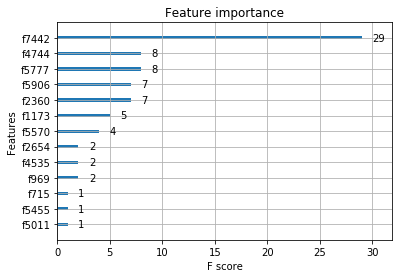

In [13]:
plot_importance(classifier)
pyplot.show()

In [14]:
import matplotlib.pyplot as plt
from sklearn import metrics

The ROC plot is generated.

In [1]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr, color = 'darkorange', label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

NameError: name 'metrics' is not defined

The analysis could be complete at this point.  The code below walks through a tuning example using grid search.  Caution is noted that the number of exmperiments can grow quickly, so tuning variables in batches is recommended.  The first step is to set the cross validation folds.  

In [16]:
cv=StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

In this example, a grid of differing values for 'max_depth', 'n_estimators', 'colsample_bytree', and 'learning_rate' is set.  These were chosen for example, but any of the parameters found in the website on top if this notebook could be included in the grid.

In [37]:
params_grid = {
    'max_depth':[5, 10, 20],
    'n_estimators':[10, 20, 30],
    'colsample_bytree': np.linspace(0.05, .2, 5),
    'learning_rate': np.linspace(0.1, 0.5, 2)
}

These are the fixed parameters for the algorithm.

In [38]:
params_fixed = {
    'objective':'binary:logistic',
    'silent':1
}

This finds the combinations of the parameters.

In [39]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring='accuracy'
)

In [40]:
import warnings
warnings.filterwarnings('ignore')

Runs the algorithm with all parameter settings.

In [41]:
bst_grid.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 0 ... 0 0], n_folds=10, shuffle=True, random_state=117),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=117, silent=1,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 20], 'n_estimators': [10, 20, 30], 'colsample_bytree': array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   ]), 'learning_rate': array([0.1, 0.5])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

Find the best score from the grid search.

In [42]:
print(bst_grid.best_score_)

0.9736842105263158


This shows the optimal values for each parameter in the grid search.  These have to be tailored to the individual inputs and desired parameter tunings.

In [43]:
print(bst_grid.best_estimator_.max_depth)
print(bst_grid.best_estimator_.n_estimators)
print(bst_grid.best_estimator_.subsample)
print(bst_grid.best_estimator_.colsample_bytree)
print(bst_grid.best_estimator_.learning_rate)

5
10
1
0.2
0.5


Re-fit the model using the optimal parameters found in the grid search.

In [44]:
from xgboost import XGBClassifier
classifier1=XGBClassifier(max_depth=5, n_estimators=10, subsample=1, 
                         colsample_bytree=0.2, learning_rate=0.5)
classifier1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Make predictions on the hold out test set.

In [45]:
y_pred1=classifier1.predict(X_test)

Find the confustion matrix.

In [47]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred1)

Variable importance plots for the test data set.

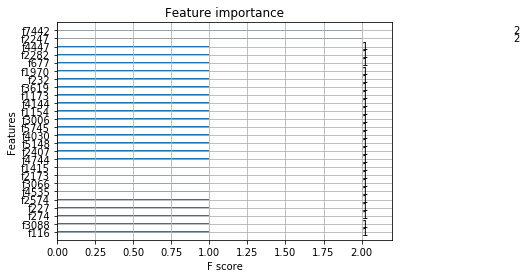

In [49]:
plot_importance(classifier1)
pyplot.show()

The ROC curve for the grid search tuned model.

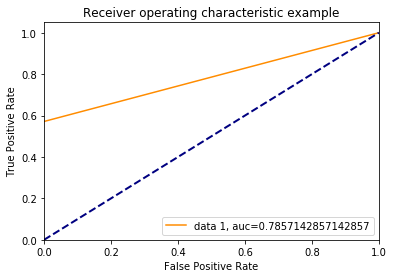

In [57]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred1)
auc = metrics.roc_auc_score(y_test, y_pred1)
plt.plot(fpr,tpr, color = 'darkorange', label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()